In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from circuit_knitting_toolbox.utils import IntegralDriver
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz
import numpy as np
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit_nature.transformers.second_quantization.electronic.active_space_transformer import (
    ActiveSpaceTransformer,
)
from qiskit_nature.algorithms.ground_state_solvers import (
    GroundStateEigensolver,
    NumPyMinimumEigensolverFactory,
)


res = []
# for R in ['0.60','0.70', '0.80', '0.90', '0.91', '0.92', '0.93', '0.94', '0.95', '0.96', '0.97', '0.98', '0.99', '1.00', '1.20', '1.40', '1.60', '1.80', '2.00', '3.00', '4.00']:
for i, R in enumerate(["0.60", "0.70"]):
    HFs = [-15.153490773865576, -14.758994968701344]
    system_data = np.load("%s_hamiltonian.xyz.npy" % R, allow_pickle=True)[0]
    orb_act = [0, 1, 2, 3, 4]
    num_molecular_orbitals = len(orb_act)
    na, nb = system_data["ne"]
    hcore = system_data["h1"]

    driver = IntegralDriver(
        hcore=system_data["h1"],
        mo_coeff=np.eye(hcore.shape[0]),
        eri=system_data["h2"],
        num_alpha=na,
        num_beta=nb,
        nuclear_repulsion_energy=system_data["h0"],
    )

    problem = ElectronicStructureProblem(driver)
    converter = QubitConverter(JordanWignerMapper())

    orb_act = [0, 1, 2, 3, 4]
    transformer = ActiveSpaceTransformer(
        num_electrons=6, num_molecular_orbitals=len(orb_act), active_orbitals=orb_act
    )
    problem_reduced = ElectronicStructureProblem(driver, [transformer])

    solver = GroundStateEigensolver(
        converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False)
    )
    result = solver.solve(problem_reduced)

    print("Classical energy = ", result.total_energies[0])

    theta = Parameter("θ")

    hop_gate = QuantumCircuit(2, name="hop_gate")
    hop_gate.h(0)
    hop_gate.cx(1, 0)
    hop_gate.cx(0, 1)
    hop_gate.ry(-theta, 0)
    hop_gate.ry(-theta, 1)
    hop_gate.cx(0, 1)
    hop_gate.h(0)

    theta_1, theta_2, theta_3, theta_4 = (
        Parameter("θ1"),
        Parameter("θ2"),
        Parameter("θ3"),
        Parameter("θ4"),
    )

    circuit = QuantumCircuit(5)
    circuit.append(hop_gate.to_gate({theta: theta_1}), [0, 1])
    circuit.append(hop_gate.to_gate({theta: theta_2}), [3, 4])
    circuit.append(hop_gate.to_gate({theta: 0}), [1, 4])
    circuit.append(hop_gate.to_gate({theta: theta_3}), [0, 2])
    circuit.append(hop_gate.to_gate({theta: theta_4}), [3, 4])

    bitstrings = [(1, 1, 1, 0, 0), (0, 1, 1, 0, 1), (1, 1, 0, 1, 0)]

    ansatz = EntanglementForgingAnsatz(
        circuit_u=circuit,
        bitstrings_u=bitstrings,
    )

    from qiskit_ibm_runtime import QiskitRuntimeService, Options

    # By default, use a local simulator to implement the Qiskit Runtime Primitives
    # service = None

    # Uncomment the following line to instead use the Qiskit Runtime Service.
    # service = QiskitRuntimeService(
    #    channel="ibm_quantum",
    #    token="API_KEY",
    # )

    # backend_names = ["ibmq_kolkata"]

    # If a single set of options are passed, it will be applied to all backends
    # level=1 (T-REx, readout error mittigation), level=2 (ZNE), level=3 (PEC)
    # options = [Options(execution={"shots": 8092}, initial_layout=[16, 14, 11, 13, 12], optimization_level=3, resilience_level =[1, 2])]

    # options = Options()
    # options.execution.shots = 8092
    # options.optimization_level = 0 # dynamical decoupling
    # options.resilience_level = 1 # Readout and ZNE
    # options.resilience.noise_factors = [1, 2, 3]
    # options.resilience.noise_amplifier = "LocalFoldingAmplifier"
    # options.resilience.extrapolator = "LinearExtrapolator"

    optimizer = COBYLA(maxiter=100)

    # p0 = np.load('vqe_forging_%s.npy'%R,allow_pickle=True).item()['parameters']

    for PAR in [1]:
        solver = EntanglementForgingGroundStateSolver(
            ansatz=ansatz,
            optimizer=optimizer,
            fix_first_bitstring=True,
            hf_energy=HFs[i],
        )
        # service=service,
        # backend_names=backend_names,
        # options=options,)
        # initial_point=PAR*p0[-1],)

        res.append(solver.solve(problem))

        np.save(
            "vqe_forging_%s.npy" % (R),
            {
                "eigenvalues": [evaluation.eigenvalue for evaluation in res[i].history],
                "schmidt": [
                    abs(evaluation.eigenstate) for evaluation in res[i].history
                ],
                "parameters": [evaluation.parameters for evaluation in res[i].history],
            },
        )

Classical energy =  (-75.28632352349251+0j)
Classical energy =  (-75.54012358825746+0j)


Energy:


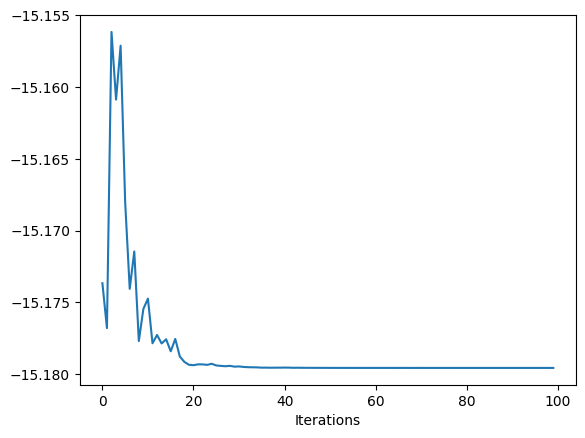

Schmidt Coefficients:


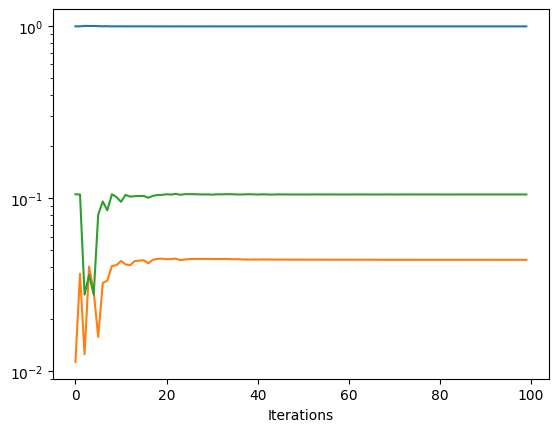

Parameters:


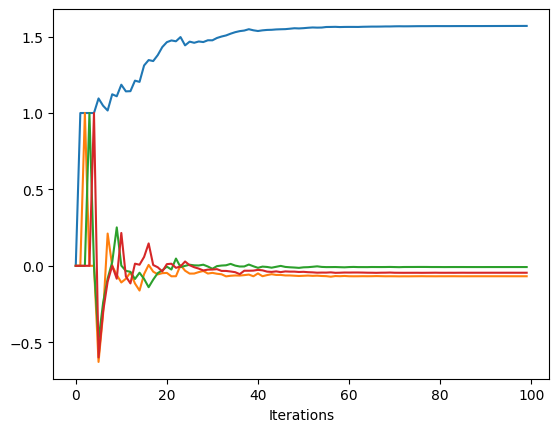

In [2]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in res[0].history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in res[0].history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in res[0].history])
plt.xlabel("Iterations")
plt.show()

Energy:


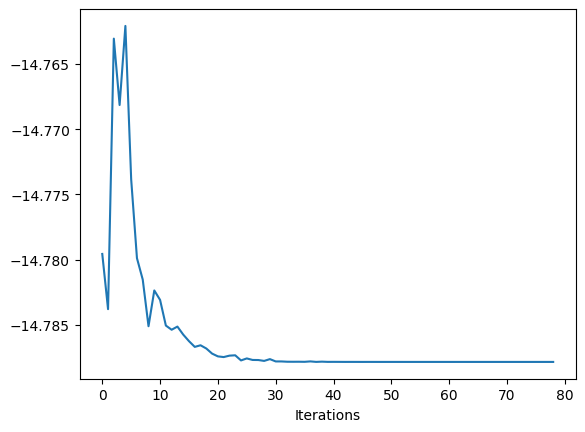

Schmidt Coefficients:


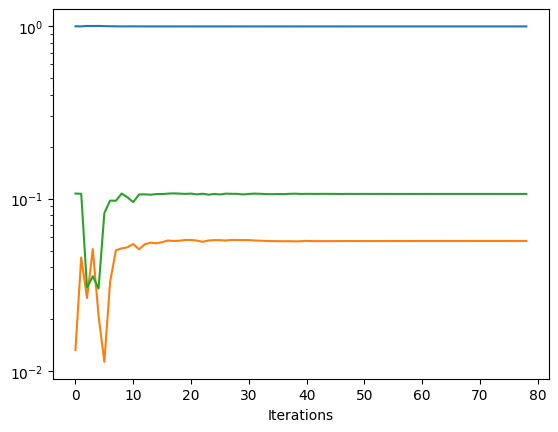

Parameters:


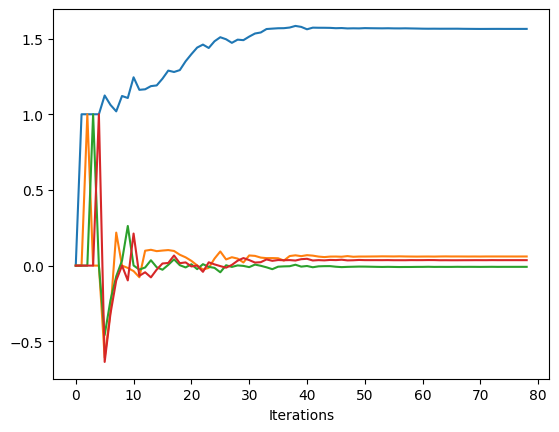

In [3]:
print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in res[1].history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in res[1].history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in res[1].history])
plt.xlabel("Iterations")
plt.show()